<a href="https://colab.research.google.com/github/SL-207/SyntheticBagClassifier/blob/main/Synthetic%20bag%20classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Download dataset

In [1]:
!pip install -qq kaggle

In [2]:
# Create and enable permissions of kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [1]:
!kaggle datasets download -d vencerlanz09/plastic-paper-garbage-bag-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/plastic-paper-garbage-bag-synthetic-images
License(s): CC-BY-SA-4.0
 98% 443M/451M [00:07<00:00, 87.6MB/s]
100% 451M/451M [00:07<00:00, 64.0MB/s]


### 2. Import dependencies

In [3]:
from pathlib import Path
import os
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm
from zipfile import ZipFile
import random
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### 3. Examine data

In [5]:
data_path = Path('data')
data_path.mkdir(exist_ok=True, parents=True)
with ZipFile('plastic-paper-garbage-bag-synthetic-images.zip', 'r') as zip:
    zip.extractall(data_path)
    print('Data has been extracted')

Data has been extracted


In [7]:
image_path = data_path / 'Bag Classes' / 'Bag Classes'

In [ ]:
for root_dir, sub_dirs, filenames in os.walk(image_path):
    print(f'{len(filenames)} images in {root_dir}')

0 images in data/Bag Classes/Bag Classes
5000 images in data/Bag Classes/Bag Classes/Plastic Bag Images
5000 images in data/Bag Classes/Bag Classes/Paper Bag Images
5000 images in data/Bag Classes/Bag Classes/Garbage Bag Images


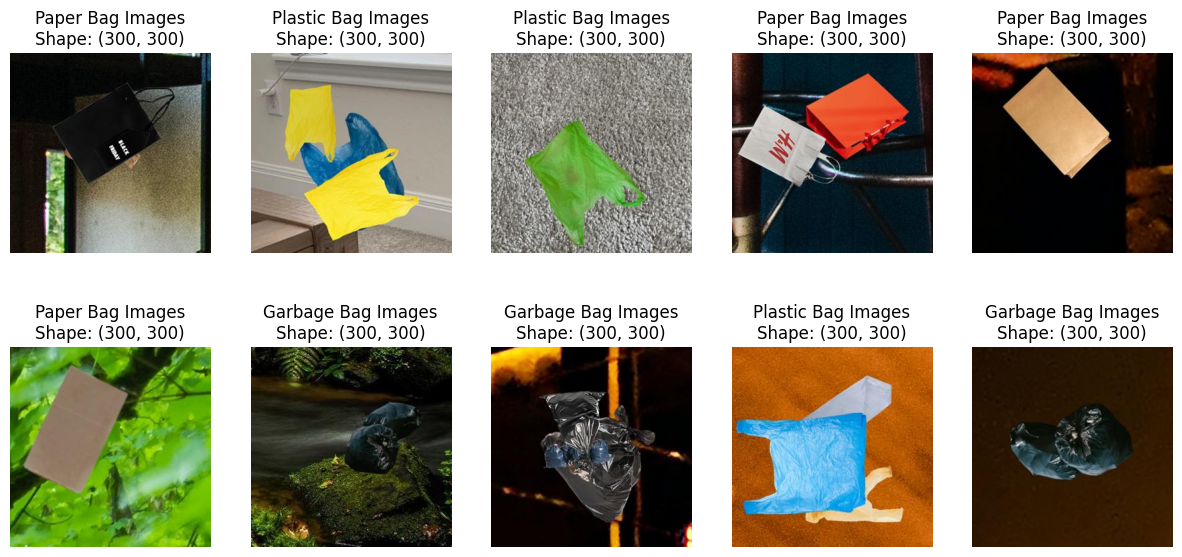

In [ ]:
def plot_random_images(image_path, n: int, display_shape: bool=True, seed: int=None):
    if seed:
        random.seed(seed)
    if n > 10:
        n = 10
        display_shape = False
        print('For display purposes, n should not exceed 10... setting n to 10 and removing shape display')

    images = list(image_path.glob('*/*.jpg'))
    selected_images = random.sample(images, k=n)

    plt.figure(figsize=(15, 7))
    for i, img in enumerate(selected_images):
        image = Image.open(img)
        plt.subplot(2, 5, i+1)
        plt.imshow(image)
        plt.axis(False)

        title = img.parent.stem
        if display_shape:
            title += f'\nShape: {image.size}'
        plt.title(title)

plot_random_images(image_path, 10)

### 4. Preprocessing and Splitting data

In [8]:
# Create transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)), transforms.RandomHorizontalFlip(), transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)), transforms.ToTensor()
])

In [9]:
from typing import Union

def preprocess(data_path: Union[Path, str],
               train_transforms: torchvision.transforms=None,
               test_transforms: torchvision.transforms=None,
               train_split: int=0.8,
               seed: int=None):
    # Create Dataset object
    dataset = datasets.ImageFolder(root=data_path,
                                    transform=None,
                                    target_transform=None)

    # Split data
    train_size = int(len(dataset) * train_split)
    test_size = len(dataset) - train_size

    if seed:
        torch.manual_seed(seed)
    train_data, test_data = random_split(dataset=dataset, lengths=[train_size, test_size])

    # Apply transforms
    # Due to folder structure, transforms applied after split
    train_data.dataset.transform = train_transforms
    test_data.dataset.transform = test_transforms
    return dataset, train_data, test_data

dataset, train_data, test_data = preprocess(data_path=image_path,
                                            train_transforms=train_transforms,
                                            test_transforms=test_transforms,
                                            seed=42)

In [ ]:
train_data[0][0].shape, train_data[0][1]

(torch.Size([3, 64, 64]), 1)

In [10]:
class_names = dataset.classes
class_names

['Garbage Bag Images', 'Paper Bag Images', 'Plastic Bag Images']

In [11]:
class_dict = dataset.class_to_idx
class_dict

{'Garbage Bag Images': 0, 'Paper Bag Images': 1, 'Plastic Bag Images': 2}

In [12]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

torch.manual_seed(42)
# Create Dataloader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)

In [ ]:
b_images, b_labels = next(iter(train_dataloader))
b_images.shape, b_labels.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
print(f'Train: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Test: {len(test_dataloader)} batches of {BATCH_SIZE}')

Train: 375 batches of 32
Test: 94 batches of 32


### 5. Build model

In [13]:
class SyntheticBagModel(nn.Module):
    def __init__(self, input_channels: int, output_features: int, hidden_units: int):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.clf_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=output_features)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.clf_block(self.conv_block2(self.conv_block1(x)))

model = SyntheticBagModel(input_channels=3, output_features=len(class_names), hidden_units=10)
model.to(device)

SyntheticBagModel(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
try:
    import torchinfo
except:
    !pip -qq install torchinfo
from torchinfo import summary
summary(model=model, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SyntheticBagModel                        [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

In [ ]:
# Trial inference
model.eval()
with torch.inference_mode():
    b_images = b_images.to(device)
    y_preds = model(b_images)
    y_probs = y_preds.softmax(dim=1)
    print(y_probs[:3]) # print first 3 predictions

tensor([[0.3486, 0.3323, 0.3191],
        [0.3486, 0.3327, 0.3187],
        [0.3488, 0.3324, 0.3188]])


### 6. Training our model

In [ ]:
def train_step(model: torch.nn.Module, train_dl: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer, device: torch.device):
    model.to(device)
    train_loss, train_acc = 0, 0
    for b, (b_images, b_labels) in enumerate(train_dl):
        b_images, b_labels = b_images.to(device), b_labels.to(device)
        model.train()
        y_logits = model(b_images)
        loss = loss_fn(y_logits, b_labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_preds = y_logits.softmax(dim=1).argmax(dim=1)
        train_acc += (y_preds == b_labels).sum().item()/BATCH_SIZE * 100
        if b % 125 == 0:
            print(f'Examined {b * BATCH_SIZE}/{len(train_dl.dataset)}')

    train_loss /= len(train_dl)
    train_acc /= len(train_dl)
    return train_loss, train_acc

In [14]:
def test_step(model: torch.nn.Module, test_dl: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, device: torch.device):
    model.to(device)
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for x, y in test_dl:
            x, y = x.to(device), y.to(device)
            y_logits = model(x)
            test_loss += loss_fn(y_logits, y).item()
            y_preds = y_logits.softmax(dim=1).argmax(dim=1)
            test_acc += (y_preds == y).sum().item()/BATCH_SIZE * 100

        test_loss /= len(test_dl)
        test_acc /= len(test_dl)

    return test_loss, test_acc

In [ ]:
def train(model: torch.nn.Module, epochs: int, train_dl: torch.utils.data.DataLoader, test_dl: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer, device: torch.device, seed: int=None):
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    if seed:
        if device == 'gpu':
            torch.cuda.manual_seed(seed)
        else:
            torch.manual_seed(seed)

    for epoch in tqdm(range(epochs)):
        print(f'Epoch {epoch}\n------')
        train_loss, train_acc = train_step(model, train_dl, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dl, loss_fn, device)
        print(f'Train loss {train_loss:.4f} | Train accuracy {train_acc:.1f}% | Test loss {test_loss:.4f} | Test accuracy {test_acc:.1f}%')

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.01)

In [ ]:
# Train model
EPOCHS = 10

start = timer()
results = train(model=model,
      epochs=EPOCHS,
      train_dl=train_dataloader,
      test_dl=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      device=device,
      seed=42)
print(f'<< Train time: {timer()-start} seconds >>')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 1.0934 | Train accuracy 39.7% | Test loss 1.0677 | Test accuracy 49.0%
Epoch 1
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.8176 | Train accuracy 59.8% | Test loss 0.7462 | Test accuracy 62.0%
Epoch 2
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.7309 | Train accuracy 63.1% | Test loss 0.7257 | Test accuracy 62.5%
Epoch 3
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.7168 | Train accuracy 64.6% | Test loss 0.7043 | Test accuracy 64.5%
Epoch 4
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.6766 | Train accuracy 68.1% | Test loss 0.6327 | Test accuracy 72.1%
Epoch 5
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.5707 | Train accuracy 76.8% | Test loss 0.5322 | Test accuracy 79.3%
Epoch 6
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Trai

In [ ]:
results

{'train_loss': [1.0934349501927694,
  0.8176440502802531,
  0.7308699254989623,
  0.716808367172877,
  0.676637417713801,
  0.5707331148783366,
  0.4779724726676941,
  0.4368946154514948,
  0.40617813070615133,
  0.3793476993640264],
 'train_acc': [39.666666666666664,
  59.8,
  63.125,
  64.60833333333333,
  68.14166666666667,
  76.84166666666667,
  81.95,
  83.61666666666666,
  85.03333333333333,
  85.80833333333334],
 'test_loss': [1.0676773811908478,
  0.7461559170104087,
  0.7257231191751805,
  0.7043207420947704,
  0.6327327150613704,
  0.5322193148288321,
  0.441905585058192,
  0.4245505486714079,
  0.3715980736974706,
  0.3662754940859815],
 'test_acc': [49.00265957446808,
  62.00132978723404,
  62.53324468085106,
  64.46143617021276,
  72.14095744680851,
  79.28856382978724,
  84.14228723404256,
  83.87632978723404,
  85.70478723404256,
  85.57180851063829]}

### 7. Saving and Reloading model

In [16]:
# Save
model_path = Path('models')
model_path.mkdir(exist_ok=True, parents=True)
torch.save(obj=model.state_dict(), f=model_path/'ppg_bag_color_model.pt')

# Reload
loaded_model = SyntheticBagModel(input_channels=3, output_features=len(class_names), hidden_units=10)
loaded_dict = torch.load(f=model_path/'ppg_bag_color_model.pt')
loaded_model.load_state_dict(loaded_dict)

### 8. Evaluating model

In [ ]:
loss, accuracy = test_step(model=loaded_model, test_dl=test_dataloader, loss_fn=loss_fn, device=device)
print(f'Model loss: {loss:.5f} | Model accuracy: {accuracy:.2f}%')

Model loss: 0.36628 | Model accuracy: 85.57%


In [ ]:
def plot_model_results(results_dict, epochs: int):
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), results_dict['train_loss'], label='Train loss')
    plt.plot(range(epochs), results_dict['test_loss'], label='Test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), results_dict['train_acc'], label='Train accuracy')
    plt.plot(range(epochs), results_dict['test_acc'], label='Test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Train vs Test accuracy')
    plt.legend()

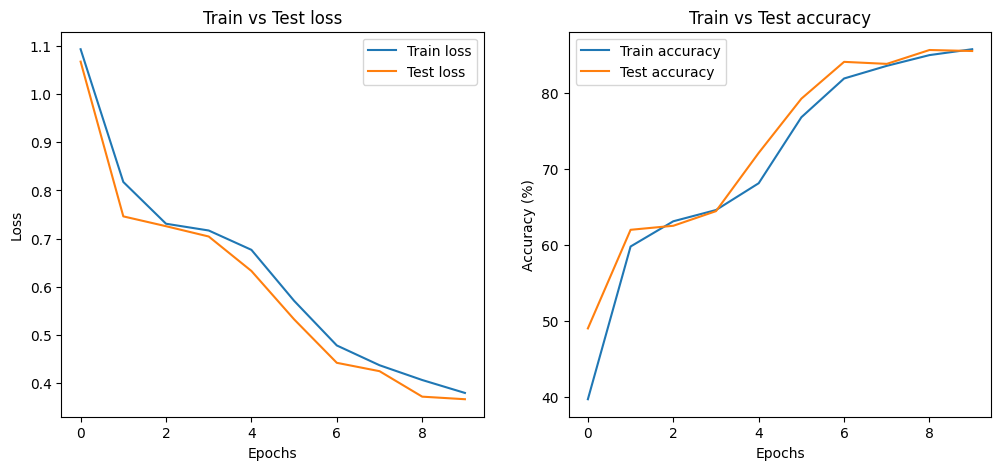

In [ ]:
plot_model_results(results_dict=results, epochs=EPOCHS)

### 9. Training a Second model (Grayscale)

In [ ]:
train_transforms_gray = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms_gray = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [ ]:
dataset, train_data_gray, test_data_gray = preprocess(data_path=image_path,
                                                      train_transforms=train_transforms_gray,
                                                      test_transforms=test_transforms_gray,
                                                      seed=42)

In [ ]:
train_data_gray[0]

(tensor([[[0.3216, 0.3255, 0.3490,  ..., 0.3961, 0.6000, 0.7608],
          [0.3098, 0.2980, 0.3333,  ..., 0.4392, 0.5098, 0.6784],
          [0.3020, 0.3137, 0.3608,  ..., 0.4667, 0.5059, 0.6039],
          ...,
          [0.0196, 0.1882, 0.4118,  ..., 0.8392, 0.8392, 0.8392],
          [0.0196, 0.1725, 0.3725,  ..., 0.8471, 0.8314, 0.8275],
          [0.0235, 0.0902, 0.2000,  ..., 0.8118, 0.8078, 0.8039]]]),
 1)

In [ ]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

torch.manual_seed
# torch.cuda.manual_seed(42)
# Create Dataloader
train_dl_gray = DataLoader(dataset=train_data_gray,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
test_dl_gray = DataLoader(dataset=test_data_gray,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)

(-0.5, 63.5, 63.5, -0.5)

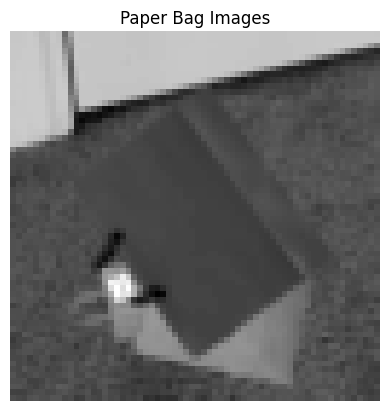

In [ ]:
b_gray_img, b_gray_label = next(iter(train_dl_gray))
plt.imshow(b_gray_img[0].permute(1,2,0), cmap='gray')
plt.title(class_names[b_gray_label[0]])
plt.axis(False)

In [ ]:
model_2 = SyntheticBagModel(input_channels=1, output_features=len(class_names), hidden_units=10)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model_2.parameters(), lr=0.01, momentum=0.9)

In [ ]:
EPOCHS = 10

start = timer()
results_2 = train(model=model_2,
      epochs=EPOCHS,
      train_dl=train_dl_gray,
      test_dl=test_dl_gray,
      loss_fn=loss_fn,
      optimizer=optimizer,
      device=device, seed=42)
print(f'<< Train time: {timer()-start} seconds >>')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.8405 | Train accuracy 55.6% | Test loss 0.7267 | Test accuracy 60.1%
Epoch 1
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.7318 | Train accuracy 61.5% | Test loss 0.6976 | Test accuracy 62.4%
Epoch 2
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.7041 | Train accuracy 62.9% | Test loss 0.7266 | Test accuracy 62.2%
Epoch 3
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.6856 | Train accuracy 64.4% | Test loss 0.6976 | Test accuracy 65.0%
Epoch 4
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.6669 | Train accuracy 66.4% | Test loss 0.6594 | Test accuracy 65.9%
Epoch 5
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.6626 | Train accuracy 66.5% | Test loss 0.6560 | Test accuracy 65.5%
Epoch 6
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Trai

In [ ]:
torch.save(model_2.state_dict(), model_path/'ppg_bag_gray_model.pt')

gray_model = SyntheticBagModel(input_channels=1, output_features=len(class_names), hidden_units=10)
loaded_dict = torch.load(model_path/'ppg_bag_gray_model.pt')
gray_model.load_state_dict(loaded_dict)

<All keys matched successfully>

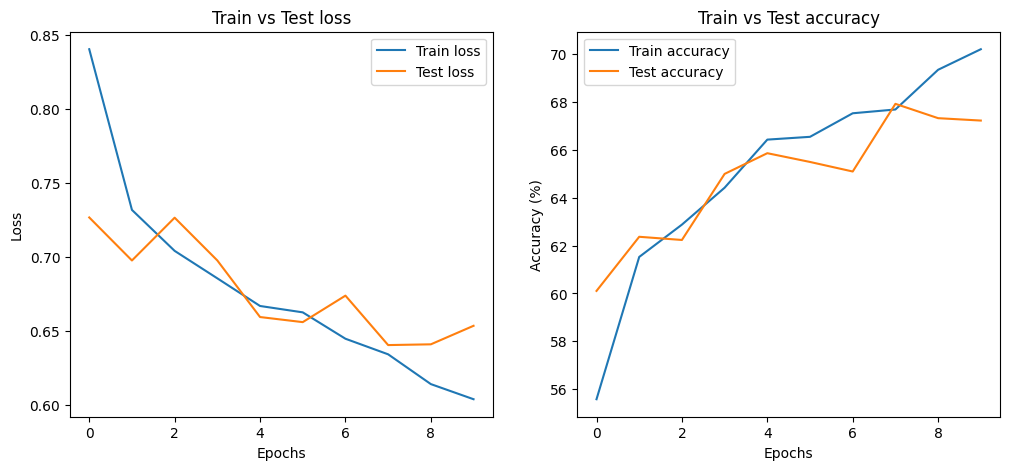

In [ ]:
plot_model_results(results_2, epochs=EPOCHS)

### 10. Comparing the two models

In [ ]:
import pandas as pd

results_df = pd.DataFrame(results)
results2_df = pd.DataFrame(results_2)
results_df

,train_loss,train_acc,test_loss,test_acc
0,1.093435,39.666667,1.067677,49.002660
1,0.817644,59.800000,0.746156,62.001330
2,0.730870,63.125000,0.725723,62.533245
3,0.716808,64.608333,0.704321,64.461436
4,0.676637,68.141667,0.632733,72.140957
5,0.570733,76.841667,0.532219,79.288564
6,0.477972,81.950000,0.441906,84.142287
7,0.436895,83.616667,0.424551,83.876330
8,0.406178,85.033333,0.371598,85.704787
9,0.379348,85.808333,0.366275,85.571809


In [ ]:
results2_df

,train_loss,train_acc,test_loss,test_acc
0,0.840451,55.583333,0.726718,60.106383
1,0.731819,61.525000,0.697627,62.367021
2,0.704124,62.875000,0.726553,62.234043
3,0.685553,64.416667,0.697635,64.993351
4,0.666871,66.425000,0.659397,65.857713
5,0.662563,66.541667,0.655953,65.492021
6,0.644728,67.525000,0.673859,65.093085
7,0.634193,67.683333,0.640441,67.918883
8,0.614061,69.341667,0.640948,67.320479
9,0.603835,70.200000,0.653472,67.220745


In [ ]:
def plot_model_comparison(results: pd.DataFrame, results_2: pd.DataFrame, epochs: int):
    plt_dim = int((len(results.columns)+0.5)/2)
    print(plt_dim)
    if results.columns.all() != results_2.columns.all():
        print('Error: column name mismatch')
        return

    plt.figure(figsize=(10,7))
    for i, col_name in enumerate(results_2.columns):
        plt.subplot(plt_dim, plt_dim, i+1)
        plt.plot(range(epochs), results.iloc[:,i], label='Color model')
        plt.plot(range(epochs), results_2.iloc[:,i], label='Grayscale model')

        y_label = col_name.split('_')[1].title()
        if 'acc' in col_name:
            y_label += ' (%)'
        plt.xlabel('Epochs')
        plt.ylabel(y_label)
        plt.title(col_name)
        plt.legend()

plot_model_comparison(results=results_df, results_2=results2_df, epochs=EPOCHS)

### 11. Refining RGB Model

In [ ]:
# Training more epochs
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=loaded_model.parameters(), lr=0.01)

EPOCHS = 5

start = timer()
results_3 = train(model=loaded_model,
                  epochs=EPOCHS,
                  train_dl=train_dataloader,
                  test_dl=test_dataloader,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  device=device,
                  seed=42)
print(f'<< Train time: {timer()-start} seconds >>')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.3028 | Train accuracy 88.6% | Test loss 0.3020 | Test accuracy 88.9%
Epoch 1
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.2931 | Train accuracy 89.1% | Test loss 0.2803 | Test accuracy 89.9%
Epoch 2
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.2877 | Train accuracy 89.0% | Test loss 0.2812 | Test accuracy 89.7%
Epoch 3
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.2790 | Train accuracy 89.5% | Test loss 0.2757 | Test accuracy 89.9%
Epoch 4
------
Examined 0/12000
Examined 4000/12000
Examined 8000/12000
Train loss 0.2742 | Train accuracy 89.6% | Test loss 0.2746 | Test accuracy 90.2%
<< Train time: 417.0546260709998 seconds >>


In [22]:
# torch.save(loaded_model, f=model_path/'ppg_bag_final_model.pt')

# final_model = torch.load(f=model_path/'ppg_bag_final_model.pt')
final_model = SyntheticBagModel(input_channels=3, output_features=len(class_names), hidden_units=10)
final_dict = torch.load(model_path/'ppg_bag_final_model.pt')
final_model.load_state_dict(final_dict)

<All keys matched successfully>

### 12. Examining final results

In [23]:
loss, acc = test_step(final_model, test_dataloader, loss_fn, device)
print(f'Model loss: {loss} | Model acc {acc}')

Model loss: 0.2745670883896503 | Model acc 90.25930851063829


In [21]:
import copy
results_comb = copy.deepcopy(results)
for key, value in results_3.items():
    results_comb[key].extend(value)

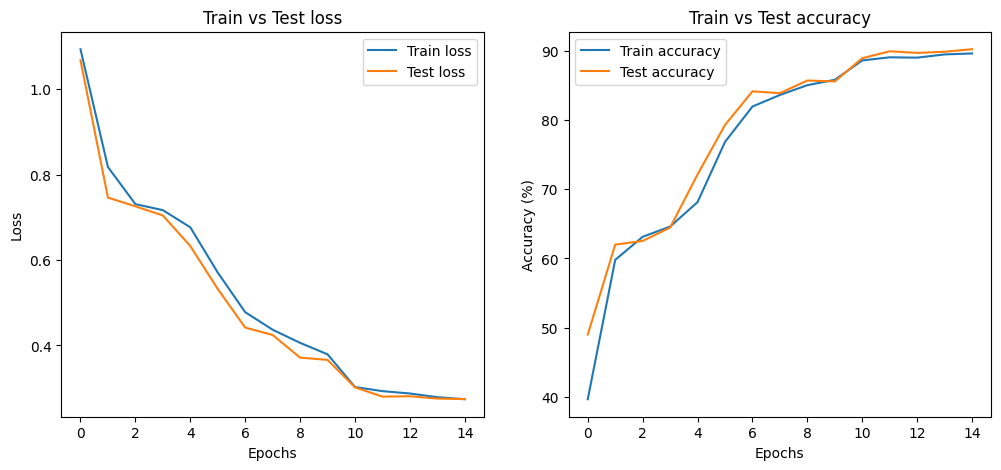

In [ ]:
# Plotting the full curve
plot_model_results(results_dict=results_comb, epochs=15)

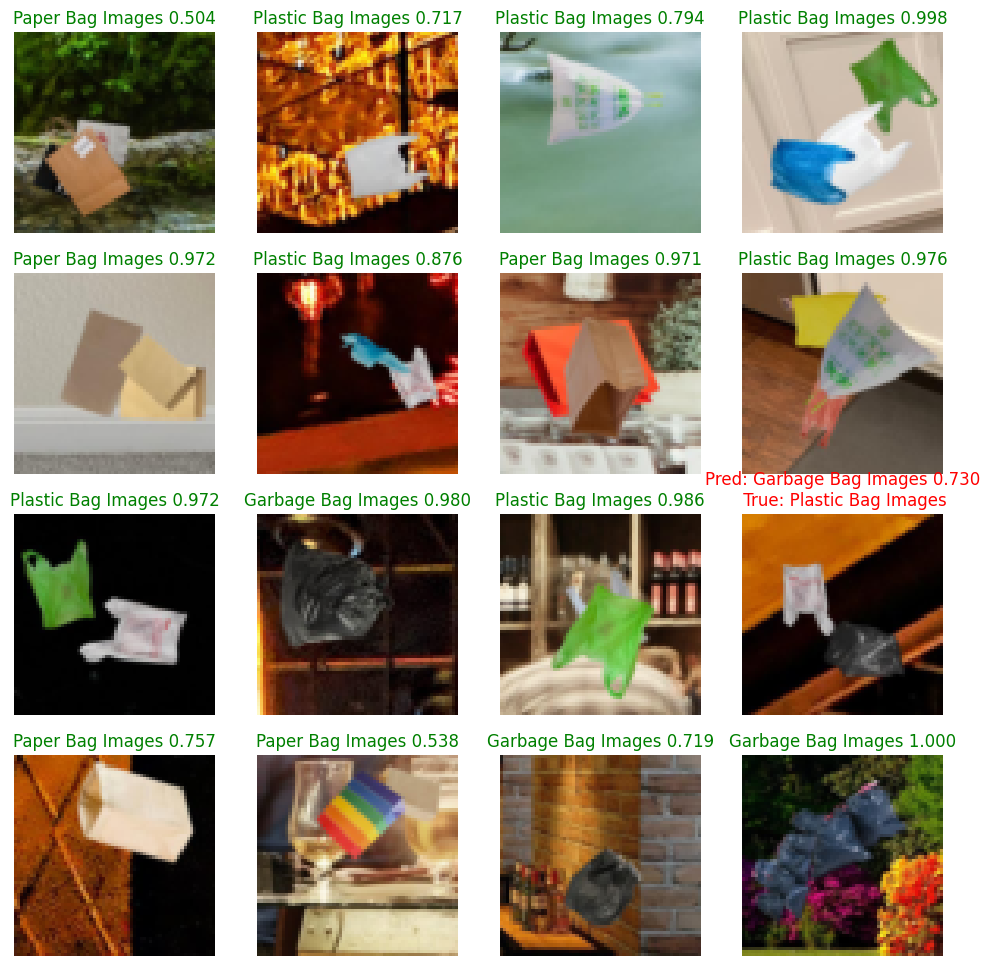

In [26]:
import math

# Plotting some predictions
def make_plot_predictions(data: torch.utils.data.dataset, model: torch.nn.Module, n_samples: int, class_names: list[str], seed: int=None):
    if seed:
        random.seed(seed)

    if n_samples > 16:
        n_samples=16
        print(f'n_samples {n_samples} exceeds maximum, setting value to 16')

    sample_idxs = range(len(data))
    selected_idxs = random.sample(sample_idxs, k=n_samples)
    plt_dim = int(math.sqrt(n_samples))

    plt.figure(figsize=(12,12))
    for i, img_idx in enumerate(selected_idxs):
        image, label = data[img_idx]

        model.eval()
        with torch.inference_mode():
            y_logits = model(image.unsqueeze(dim=0))
            y_probs = y_logits.softmax(dim=1).squeeze()
            y_pred = y_probs.argmax(dim=0).item()

        plt.subplot(plt_dim, plt_dim, i+1)
        image = image.permute(1,2,0)
        plt.imshow(image)
        plt.axis(False)

        confidence = y_probs[y_pred]
        if label == y_pred:
            plt.title(f'{class_names[y_pred]} {confidence:.3f}', c='g')
        else:
            plt.title(f'Pred: {class_names[y_pred]} {confidence:.3f}\n True: {class_names[label]}', c='r')

make_plot_predictions(data=test_data, model=final_model, n_samples=16, class_names=class_names)

In [27]:
try:
    import torchmetrics
except:
    !pip install -qq torchmetrics

from torchmetrics import Precision, Recall, F1Score, ConfusionMatrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 24.9 MB/s eta 0:00:00


In [63]:
# Evaluating with different metrics
prec_fn = Precision(task='multiclass', average='macro', num_classes=len(class_names))
recall_fn = Recall(task='multiclass', average='macro', num_classes=len(class_names))
f1_score_fn = F1Score(task='multiclass', average='macro', num_classes=len(class_names))
conf_mat_fn = ConfusionMatrix(task='multiclass', num_classes=len(class_names))

y_preds, y_labels = [], []
final_model.eval()
with torch.inference_mode():
    for x, y in test_dataloader:
        y_logits = final_model(x)
        y_pred = y_logits.softmax(dim=1).argmax(dim=1).squeeze(dim=0)
        y_preds.append(y_pred)
        y_labels.append(y)
y_preds = torch.cat(y_preds)
y_labels = torch.cat(y_labels)

precision = prec_fn(y_preds, y_labels)
recall = recall_fn(y_preds, y_labels)
f1_score = f1_score_fn(y_preds, y_labels)
mat = conf_mat_fn(y_preds, y_labels)

print(f'Final Model - Precision: {precision:.3f} | Recall: {recall:.3f} | F1 score: {f1_score:.3f}')

Final Model - Precision: 0.907 | Recall: 0.904 | F1 score: 0.905


{'Garbage Bag Images': 0, 'Paper Bag Images': 1, 'Plastic Bag Images': 2}


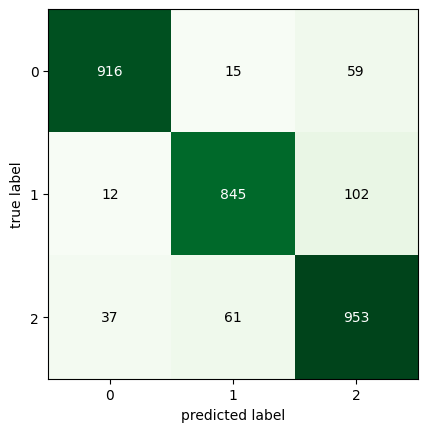

In [59]:
# Confusion matrix
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(conf_mat=mat.cpu().numpy(), cmap='Greens')
print(class_dict)

### 13. Preparing to deploy model

Input an image path: /content/data/Bag Classes/Bag Classes/Garbage Bag Images/00000004.jpg


'Garbage Bag Images'

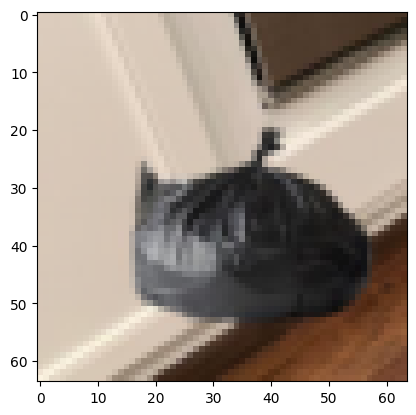

In [75]:
from torchvision.io import read_image

path = input('Input an image path: ')
image = read_image(str(path)).type(torch.float)
image /= 255
resize = transforms.Resize(size=(64,64))
image = resize(image)
plt.imshow(image.permute(1,2,0))

final_model.eval()
with torch.inference_mode():
    y_logits = final_model(image.unsqueeze(dim=0))
    y_probs = y_logits.softmax(dim=1)
    y_pred = y_probs.argmax(dim=1).squeeze(dim=0)
class_names[y_pred]